In [1]:
# import libraries

import os
import torch 
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import math
import mygene
import sklearn.preprocessing as sk
import seaborn as sns
from sklearn import metrics
from sklearn.feature_selection import VarianceThreshold
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from torch.utils.data.sampler import WeightedRandomSampler
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import roc_auc_score
from sklearn.metrics import average_precision_score, precision_recall_curve
import random
from random import randint
from sklearn.model_selection import StratifiedKFold
import warnings

# Suppress all warnings
warnings.filterwarnings("ignore")

In [2]:
# define directories

cell_line_dir = "/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC/"
models_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_Mutation_CNA/Models/"
DEGs_dir = "/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi/"
dataset_dir = "/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/"
pdx_data_dir = "/Volumes/Expansion/Thesis Work/Datasets/PDX/Expression/"
em_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_Mutation/Predictions/"
ec_dir = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_CNA/Predictions/"
save_results_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_Mutation_CNA/Predictions/"
save_figures_to = "/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_Mutation_CNA/Figures/"

In [3]:
# set random seeds

torch.manual_seed(42)
random.seed(42)

In [4]:
# change directory to read GDSC cell line details

os.chdir(cell_line_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Supplementary Files/GDSC


In [5]:
# read GDSC cell line details table

GDSC_cell_line_details = pd.read_excel("GDSC_Cell_Lines_Details.xlsx", keep_default_na = False)
GDSC_cell_line_details.set_index("COSMIC identifier", inplace = True)
GDSC_cell_line_details.tail()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties
COSMIC identifier,,,,,,,,,,,,
1298218,KP-2,Y,N,Y,N,Y,pancreas,pancreas,PAAD,,D/F12,Adherent
1330932,KO52,Y,Y,N,N,N,leukemia,acute_myeloid_leukaemia,LAML,MSS/MSI-L,D/F12,NA
1331030,SC-1,Y,Y,N,N,N,lymphoma,B_cell_lymphoma,DLBC,MSS/MSI-L,R,NA
1503373,U-CH2,Y,Y,N,N,N,bone,bone_other,,MSS/MSI-L,D/F12,Adherent
,TOTAL:,1001,996,968,957,990,,,,,,


In [6]:
# change directory to read GDSC expression dataset (CYTOi)

os.chdir(dataset_dir + "/exprs/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs


In [7]:
# read GDSC expression dataset (CYTOi)

GDSCE = pd.read_csv("GDSC_exprs.z.CYTOi.tsv", 
                    sep = "\t", index_col=0, decimal = ",")
GDSCE = pd.DataFrame.transpose(GDSCE)
GDSCE.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,107984199,107984208,107984325,107984411,107984648,107984889,107984989,107986313,107986782,107986810
683665,-0.4711563767951986,-0.1857522957766964,0.9702409548662462,-0.4081281805960821,-0.4161511169999803,-0.4384159723467665,-1.154692246005183,0.5262132484107975,-0.7950924576033422,-0.6337442716864214,...,1.283534690590172,-0.3367265464586691,-0.0039762988723447,0.7378729872604209,0.9757614264575688,0.1494417647095801,2.062294063911948,-0.8140636761719959,0.2870333828833719,0.9524265085537148
684055,1.3565140948247052,-0.277542411913307,0.0887087882196536,-0.2754829982302413,-0.5153856346587746,-0.6248712076433911,0.1243408990866293,-1.2699667684674136,2.0788360886382717,2.5197991997459197,...,-0.5571028630154293,-1.724090733574364,-0.3749080365068901,-0.0016055431935905,-0.3788535663547365,-1.3502092798315848,0.6949790577550328,0.4333032198982747,-0.1280986270308099,-1.629249958712223
684057,0.6510004960254864,1.6578876382433665,-0.4977106390881842,-0.1212172092933644,-0.398455281697677,-0.2804901106672752,0.6455898116420014,0.215833091774836,-0.1723595788875009,-0.2170870770552223,...,-0.024863133395904,0.4073439017665206,-0.4440356638831038,0.8630347078663075,1.4486171428489227,-1.4777214830771732,0.5220400480464272,0.6441211958947753,0.9057518606131394,0.3018783753479829


In [8]:
# change directory to read GDSC mutation dataset (CYTOi)

os.chdir(dataset_dir + "/mutations/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations


In [9]:
# read GDSC mutation dataset (CYTOi)

GDSCM = pd.read_csv("GDSC_mutations.CYTOi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCM.drop_duplicates(keep='last')
GDSCM = pd.DataFrame.transpose(GDSCM)
GDSCM = GDSCM.loc[:, ~GDSCM.columns.duplicated()]

GDSCM.head()

,143872,728577,2,2050,10243,79365,256006,4609,118788,113675,...,26517,28972,53917,283507,514,339210,64981,7335,5739,83442
683665,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684055,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684057,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684059,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
684062,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [10]:
# change directory to read GDSC CNA dataset (CYTOi)

os.chdir(dataset_dir + "/CNA/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA


In [11]:
# read GDSC CNA dataset (CYTOi)

GDSCC = pd.read_csv("GDSC_CNA.CYTOi.tsv",
                    sep="\t", index_col=0, decimal=".")
GDSCC.drop_duplicates(keep='last')
GDSCC = pd.DataFrame.transpose(GDSCC)
GDSCC = GDSCC.loc[:, ~GDSCC.columns.duplicated()]

In [12]:
# change directory to read GDSC response dataset (CYTOi)

os.chdir(dataset_dir + "/response/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response


In [13]:
# read GDSC response dataset (CYTOi)

GDSCR = pd.read_csv("GDSC_response.CYTOi.tsv",
                    sep="\t",
                    index_col=0,
                    decimal=",")
filter = GDSCR["drug"] != "Afatinib (rescreen)"
GDSCR = GDSCR.loc[filter, ]
GDSCR.dropna(inplace=True)
GDSCR.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
GDSCR["response"] = GDSCR.loc[:, "response"].apply(lambda x: d[x])

GDSCR.head()

,response,logIC50,drug,exprs,CNA,mutations
sample_name,,,,,,
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1
683665,0,1.72219893512551,PF-562271,1,1,1
683665,0,1.70736111120553,IPA-3,1,1,1


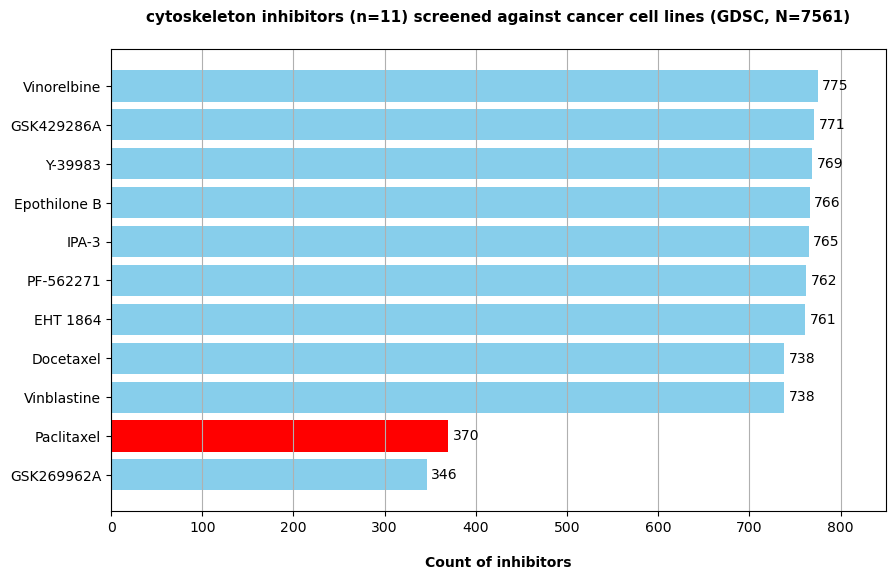

In [14]:
# plot cytoskeleton inhibitors with their counts

gdsc_drugs = dict(GDSCR["drug"].value_counts())
gdsc_drugs = dict(sorted(gdsc_drugs.items(), key=lambda item: item[1], reverse=False))
drug_names = list(gdsc_drugs.keys())
drug_values = list(gdsc_drugs.values())

plt.figure(figsize=(10, 6))
bars = plt.barh(drug_names, drug_values, color='skyblue')

for bar, value in zip(bars, drug_values):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')
    
bars = []

for name, value in zip(drug_names, drug_values):
    if name == "Paclitaxel":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))
plt.xlabel('Count of inhibitors', fontweight='bold', labelpad=15)
plt.title(f'cytoskeleton inhibitors (n={len(drug_names)}) screened against cancer cell lines (GDSC, N={sum(drug_values)})',
          fontweight='bold',
          fontsize=11,
          pad=20)
plt.xlim(0, 850)  
plt.grid(axis='x')
os.makedirs(save_figures_to, exist_ok = True)
plt.savefig(save_figures_to + 'cytoskeleton Inhibitors with Their Counts (GDSC, Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [15]:
# print count of cell lines for each drug (CYTOi)

GDSCR["drug"].value_counts()

drug
Vinorelbine     775
GSK429286A      771
Y-39983         769
Epothilone B    766
IPA-3           765
PF-562271       762
EHT 1864        761
Vinblastine     738
Docetaxel       738
Paclitaxel      370
GSK269962A      346
Name: count, dtype: int64

In [16]:
# change directory to read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

os.chdir(dataset_dir + "exprs_homogenized/")
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/exprs_homogenized


In [17]:
# read PDX expression dataset homogenized with GDSC expression dataset (Paclitaxel)

PDXEpaclitaxel = pd.read_csv("PDX_exprs.Paclitaxel.eb_with.GDSC_exprs.Paclitaxel.tsv",
                   sep = "\t", index_col=0, decimal = ",")
PDXEpaclitaxel = pd.DataFrame.transpose(PDXEpaclitaxel)
PDXEpaclitaxel.head(3)

ENTREZID,1,2,9,10,12,13,14,15,16,18,...,100507206,100507254,100507436,100507472,100526773,100527978,100532746,100820829,102724473,105375355
X-1008,5.1683455924601,6.40148605928778,5.14735257900894,2.62182669498089,5.65801642244848,2.56126582112594,7.9002150761815,2.99037104024989,9.07138836072349,2.93107188443328,...,2.51273514040916,3.16885840754458,7.88710414124411,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,3.95569877310649,3.86826539821721,2.24540260166309
X-1156,5.64285976724198,6.16403060339034,6.56682953977831,2.62182669498089,2.20555612143949,2.68000643826337,8.28747895280708,2.40648953950849,6.85807798266578,3.44682372154383,...,2.6201404525098,3.05224139425924,6.43259864910441,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,5.32315076936616,3.85690425090814,2.27121625384186
X-1172,2.76326591576383,6.63737682195879,5.67675838505579,2.79473965144091,3.52596051559272,5.74258764261314,8.70184553811941,2.66283398075993,9.95397018105127,3.64884172474159,...,2.68566229198938,3.11779249946595,5.44497097056128,2.86414718037944,2.83357312932769,2.31326216200341,2.42412318078189,2.45399733779172,4.19271392722119,2.21127349569176


In [18]:
# change directory to read PDX mutation dataset (Paclitaxel)

os.chdir(dataset_dir + "mutations")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/mutations'

In [19]:
# read PDX mutation dataset (Paclitaxel)

PDXMpaclitaxel = pd.read_csv("PDX_mutations.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXMpaclitaxel.drop_duplicates(keep='last')
PDXMpaclitaxel = pd.DataFrame.transpose(PDXMpaclitaxel)
PDXMpaclitaxel = PDXMpaclitaxel.loc[:, ~PDXMpaclitaxel.columns.duplicated()]

PDXMpaclitaxel.head(3)

ENTREZID,3075.0,171017.0,2058.0,79890.0,7701.0,3104.0,4642.0,9778.0,100132406.0,23607.0,...,253738.0,154807.0,79140.0,6307.0,6352.0,56005.0,115650.0,64946.0,5777.0,253639.0
X-1008,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1156,0.0,-0.05,0.0,-0.05,0.0,0.0,0.0,-0.05,-0.05,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
X-1172,0.0,-0.05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [20]:
# change directory to read PDX CNA dataset (Paclitaxel)

os.chdir(dataset_dir + "CNA")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/CNA'

In [21]:
# read PDX CNA dataset (Paclitaxel)

PDXCpaclitaxel = pd.read_csv("PDX_CNA.Paclitaxel.tsv",
                        sep="\t", index_col=0, decimal=",")
PDXCpaclitaxel.drop_duplicates(keep='last')
PDXCpaclitaxel = pd.DataFrame.transpose(PDXCpaclitaxel)
PDXCpaclitaxel = PDXCpaclitaxel.loc[:, ~PDXCpaclitaxel.columns.duplicated()]

PDXCpaclitaxel.head(3)

ENTREZID,1,2,3,9,10,12,13,14,15,16,...,101340252,102723547,102724473,103091865,105375355,107126285,109623460,109731405,118126072,128385369
X-1008,-0.3219280948873623,0.0,0.0,-1.6896598793878497,-1.6896598793878497,0.0,0.6182386555954547,-0.5145731728297583,0.0,-0.3400754415976217,...,0.3276873641760471,-0.3219280948873623,0.3785116232537298,0.0,-0.3129393116601076,0.0,-1.888968687611256,-0.3400754415976217,-0.7369655941662062,0.0
X-1156,0.9781956296816516,0.7004397181410922,0.7004397181410922,-0.2429767534925404,-0.2429767534925404,-0.2863041851566411,0.5607149544744789,0.3895668117627256,-0.2688167584278,-0.2688167584278,...,0.4594316186372972,0.0,-0.4246876693125631,-0.7369655941662062,0.0,1.100977647724821,-0.3770696490798233,-0.3219280948873623,-0.6551715030025588,0.0
X-1172,0.0,0.0,0.0,-0.5145731728297583,-0.5145731728297583,0.0,0.4276061727818994,0.4222330006830478,0.9297909977185974,0.0,...,-0.5994620704162712,-0.6780719051126377,0.3895668117627256,-0.4639470997597902,0.859969548221026,0.5109619192773793,-0.2863041851566411,0.0,0.0,1.0214797274104517


In [22]:
# variance threshold for GDSC Expression dataset (CYTOi)

selector = VarianceThreshold(0.05)
selector.fit_transform(GDSCE)
GDSCE = GDSCE[GDSCE.columns[selector.get_support(indices=True)]]

In [23]:
# fill NA values and binarize GDSC mutation and CNA datasets (CYTOi)

GDSCM = GDSCM.fillna(0)
GDSCM[GDSCM != 0.0] = 1
GDSCC = GDSCC.fillna(0)
GDSCC[GDSCC != 0.0] = 1

In [24]:
# select shared genes between GDSC and PDX expression, mutation, and CNA datasets 

ls = GDSCE.columns.intersection(GDSCM.columns)
ls = ls.intersection(GDSCC.columns)
ls = ls.intersection(PDXEpaclitaxel.columns)
ls = ls.intersection(PDXMpaclitaxel.columns)
ls = ls.intersection(PDXCpaclitaxel.columns)

ls = pd.unique(ls)

print(f"GDSC and PDX # of common genes: {ls.shape[0]}")

GDSC and PDX # of common genes: 13815


In [25]:
# select shared samples between GDSC expression, mutation, CNA, and response datasets (CYTOi)

ls2 = GDSCE.index.intersection(GDSCM.index)
ls2 = ls2.intersection(GDSCC.index)
ls2 = ls2.intersection(GDSCR.index)

print(f"GDSC # of common cell lines: {ls2.shape[0]}")

GDSC # of common cell lines: 801


In [26]:
# subset shared genes and samples in GDSC expression, mutation, CNA, and response datasets

GDSCE = GDSCE.loc[ls2, ls]
GDSCM = GDSCM.loc[ls2, ls]
GDSCC = GDSCC.loc[ls2, ls]
GDSCR = GDSCR.loc[ls2, :]

print(f"GDSC # of common samples and genes (Expression): {GDSCE.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCM.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCC.shape}")
print(f"GDSC # of samples (Response): {GDSCR.shape[0]}")

GDSC # of common samples and genes (Expression): (801, 13815)
GDSC # of common samples and genes (Mutation): (801, 13815)
GDSC # of common samples and genes (CNA): (801, 13815)
GDSC # of samples (Response): 7561


In [27]:
# select shared samples between PDX expression, mutation, and CNA datasets (Paclitaxel) 

ls3 = PDXEpaclitaxel.index.intersection(PDXMpaclitaxel.index)
ls3 = ls3.intersection(PDXCpaclitaxel.index)

print(f"PDX # of common samples (Paclitaxel): {ls3.shape[0]}")

PDX # of common samples (Paclitaxel): 43


In [28]:
# select shared genes and samples between PDX expression, mutation, and CNA datasets (Paclitaxel)

PDXEpaclitaxel = PDXEpaclitaxel.loc[ls3, ls]
PDXMpaclitaxel = PDXMpaclitaxel.loc[ls3, ls]
PDXCpaclitaxel = PDXCpaclitaxel.loc[ls3, ls]

print(f"PDX # of common samples and genes for Expression (Paclitaxel): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Mutation (Paclitaxel): {PDXMpaclitaxel.shape}")
print(f"PDX # of common samples and genes for CNA (Paclitaxel): {PDXCpaclitaxel.shape}\n")

PDX # of common samples and genes for Expression (Paclitaxel): (43, 13815)
PDX # of common samples and genes for Mutation (Paclitaxel): (43, 13815)
PDX # of common samples and genes for CNA (Paclitaxel): (43, 13815)



In [29]:
# change directory to read DEGs (CYTOi)

os.chdir(DEGs_dir)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/GDSC_DEGs_inhibitors/CYTOi


In [30]:
# read DEGs (CYTOi)

DEGs_filtered_data = pd.read_excel("CYTOi_Differentially_Expressed_Genes (EnsemblID).xlsx",
                                    sheet_name = "Common DEGs")
print(f"There are {DEGs_filtered_data.shape[0]} DEGs (p-adjusted < 0.05) among cytoskeleton inhibitors\n")

DEGs_filtered_data.head()

There are 845 DEGs (p-adjusted < 0.05) among cytoskeleton inhibitors



,Gene Symbol,Frequency
0,PTGR1,8
1,SDC4,8
2,TPD52L1,8
3,S100A16,8
4,MYOF,8


In [31]:
# get gene symbol from mygene database

mg = mygene.MyGeneInfo()
DEGs_entrez_id = mg.querymany(DEGs_filtered_data["Gene Symbol"], 
                              species="human", 
                              scopes = "symbol",
                              field = "entrezgene",
                              as_dataframe=True)["entrezgene"]
DEGs_entrez_id = pd.unique(DEGs_entrez_id.dropna())
DEGs_entrez_id = pd.Series(DEGs_entrez_id)

result = mg.query("SLC22A18", species="human", scopes="symbol", fields="entrezgene")
DEGs_entrez_id = pd.concat([DEGs_entrez_id, pd.Series(str(result["hits"][1]["entrezgene"]))], ignore_index=True)

DEGs_entrez_id.shape[0]

2 input query terms found dup hits:	[('CLECL1P', 2), ('CAST', 2)]
1 input query terms found no hit:	['SLC22A18']


845

In [32]:
# assign GDSC datasets to new variables

exprs_z = GDSCE
mut = GDSCM
cna = GDSCC
responses = GDSCR

In [33]:
# GDSC response dataset

responses = GDSCR
responses.head(3)

,response,logIC50,drug,exprs,CNA,mutations
683665,0,-3.64728727366553,Paclitaxel,1,1,1
683665,0,1.27553797434562,GSK269962A,1,1,1
683665,0,-4.54428601391955,Vinorelbine,1,1,1


In [34]:
# list drug names in GDSC response dataset

drugs = set(responses["drug"].values)
drugs

{'Docetaxel',
 'EHT 1864',
 'Epothilone B',
 'GSK269962A',
 'GSK429286A',
 'IPA-3',
 'PF-562271',
 'Paclitaxel',
 'Vinblastine',
 'Vinorelbine',
 'Y-39983'}

In [35]:
# convert Entrez gene IDs to integer

responses.index = responses.index.astype(int)
responses.index

Index([ 683665,  683665,  683665,  683665,  683665,  683665,  683665,  683665,
        683665,  683665,
       ...
       1299050, 1299050, 1299050, 1299050, 1299050,  910941,  910941, 1659818,
       1659818, 1659818],
      dtype='int64', length=7561)

In [36]:
# merge GDSC cell line details with response dataset

dat = pd.merge(GDSC_cell_line_details,
         responses,
         left_index = True, 
         right_index=True,
         how = "inner")

dat["GDSC\nTissue descriptor 1"].value_counts()
dat.head()

,Sample Name,Whole Exome Sequencing (WES),Copy Number Alterations (CNA),Gene Expression,Methylation,Drug\nResponse,GDSC\nTissue descriptor 1,GDSC\nTissue\ndescriptor 2,Cancer Type\n(matching TCGA label),Microsatellite \ninstability Status (MSI),Screen Medium,Growth Properties,response,logIC50,drug,exprs,CNA,mutations
COSMIC identifier,,,,,,,,,,,,,,,,,,
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,-4.02193345692394,Paclitaxel,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,4.08827572251529,GSK269962A,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,1,-6.33038616970938,Vinorelbine,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,1.24194812524286,PF-562271,1,1,1
906794,A253,Y,Y,Y,Y,Y,aero_dig_tract,head and neck,,MSS/MSI-L,D/F12,Adherent,0,2.7176429750138,IPA-3,1,1,1


In [37]:
# get tissue descriptors

dat["GDSC\nTissue\ndescriptor 2"].value_counts().head()

GDSC\nTissue\ndescriptor 2
lung_NSCLC_adenocarcinoma    492
lung_small_cell_carcinoma    467
glioma                       451
melanoma                     418
breast                       405
Name: count, dtype: int64

In [38]:
# get count of total BRCA and NSCLC tissues

tissues = dat["GDSC\nTissue\ndescriptor 2"].value_counts()
count_selected_tissues = tissues["breast"].astype(int) + \
                         tissues["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues["lung_NSCLC_large cell"].astype(int) + \
                         tissues["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues["lung_NSCLC_not specified"].astype(int) + \
                         tissues["lung_NSCLC_carcinoid"].astype(int) 
count_selected_tissues

1205

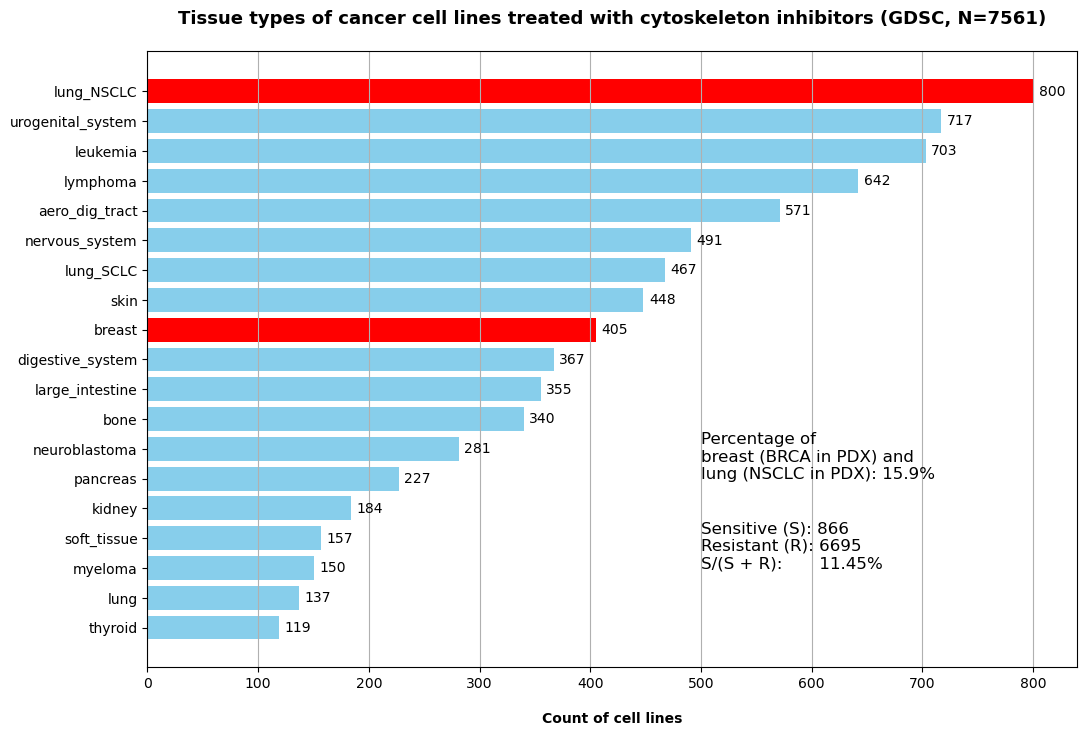

In [39]:
# plot tissue types of cancer cell lines treated with cytoskeleton inhibitors

gdsc_tissue_counts = dat["GDSC\nTissue descriptor 1"].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with cytoskeleton inhibitors (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 5, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(500, 13, 
         f'Percentage of \nbreast (BRCA in PDX) and \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(500, 16, 
         f'Sensitive (S): {dat[["response"]].value_counts()[1]} \nResistant (R): {dat[["response"]].value_counts()[0]} \nS/(S + R):       {round(dat[["response"]].value_counts()[1]/(sum(dat[["response"]].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')


plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with cytoskeleton inhibitors (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [40]:
# list count of cell lines as to tissues treated with paclitaxel

filter = (dat["drug"] == "Paclitaxel")
dat.loc[filter,"GDSC\nTissue descriptor 1"].value_counts()

GDSC\nTissue descriptor 1
leukemia             64
lymphoma             57
lung_SCLC            35
nervous_system       25
neuroblastoma        23
lung_NSCLC           20
bone                 20
skin                 19
urogenital_system    16
large_intestine      15
aero_dig_tract       14
myeloma              13
digestive_system     12
breast               11
kidney               10
soft_tissue           9
lung                  3
pancreas              2
thyroid               2
Name: count, dtype: int64

In [41]:
# list count of cell lines as to tissues treated with paclitaxel

tissues_drugs = dat[["GDSC\nTissue descriptor 1","GDSC\nTissue\ndescriptor 2","drug"]]

filter = (tissues_drugs["drug"] == "Paclitaxel")
tissues_drug = tissues_drugs.loc[filter,"GDSC\nTissue\ndescriptor 2"].value_counts()

tissues_drug.head()

GDSC\nTissue\ndescriptor 2
lung_small_cell_carcinoma    35
acute_myeloid_leukaemia      25
neuroblastoma                23
B_cell_lymphoma              23
glioma                       23
Name: count, dtype: int64

In [42]:
# count of BRCA and NSCLC cell lines treated with paclitaxel

count_selected_tissues = tissues_drug["breast"].astype(int) + \
                         tissues_drug["lung_NSCLC_adenocarcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_large cell"].astype(int) + \
                         tissues_drug["lung_NSCLC_squamous_cell_carcinoma"].astype(int) + \
                         tissues_drug["lung_NSCLC_not specified"].astype(int) + \
                         tissues_drug["lung_NSCLC_carcinoid"].astype(int) 

count_selected_tissues

31

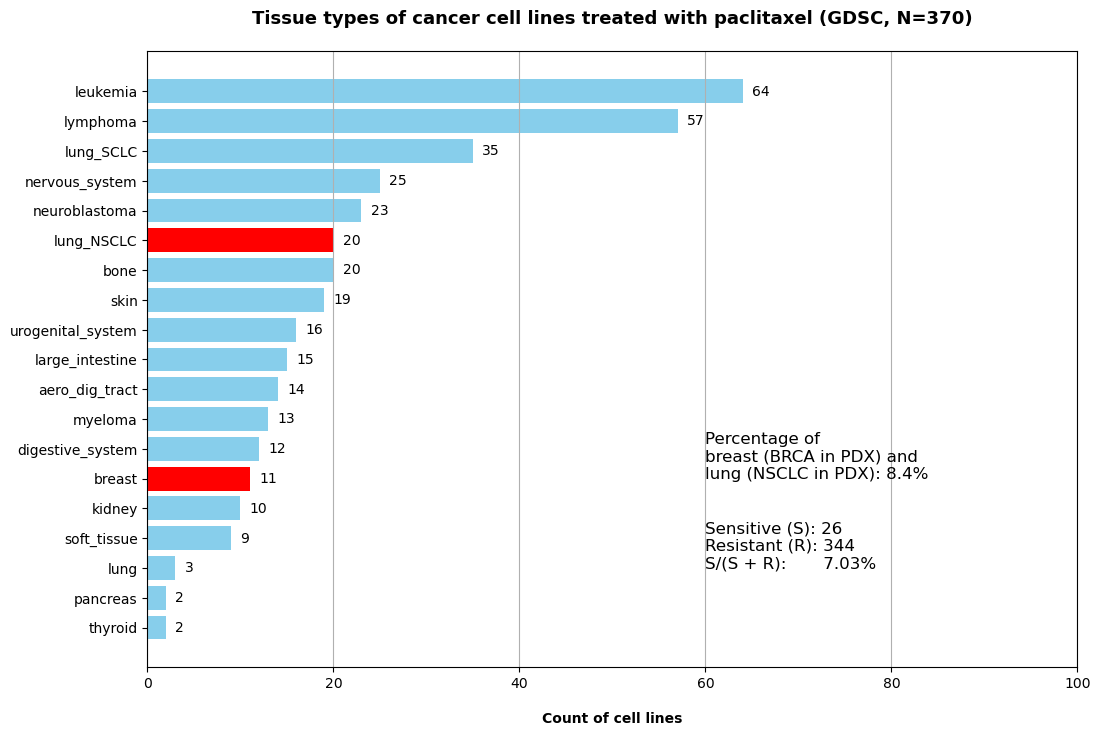

In [43]:
# plot tissue types of cancer cell lines treated with paclitaxel

gdsc_tissue_counts =  tissues_drugs.loc[filter, 'GDSC\nTissue descriptor 1'].value_counts()
tissue_names = list(gdsc_tissue_counts.index)
tissue_counts = list(gdsc_tissue_counts)

plt.figure(figsize=(12, 8))
plt.barh(tissue_names, tissue_counts, color='skyblue')
plt.xlabel('Count of cell lines', fontweight='bold', labelpad = 15)
plt.title(f'Tissue types of cancer cell lines treated with paclitaxel (GDSC, N={sum(tissue_counts)})',
           fontweight='bold',
           fontsize=13,
           pad=20)
plt.gca().invert_yaxis() 
plt.xlim(0, 100)
plt.grid(axis='x')

bars = plt.barh(tissue_names, tissue_counts, color='skyblue')

for bar, value in zip(bars, tissue_counts):
    plt.text(value + 1, bar.get_y() + bar.get_height()/2, str(value), va='center')

bars = []

for name, value in zip(tissue_names, tissue_counts):
    if name == "breast" or name == "lung_NSCLC":
        bars.append(plt.barh(name, value, color='red'))
    else:
        bars.append(plt.barh(name, value, color='skyblue'))

plt.text(60, 13, 
         f'Percentage of \nbreast (BRCA in PDX) and \nlung (NSCLC in PDX): {round(count_selected_tissues/sum(tissue_counts) * 100, 1)}%', 
         fontsize=12, 
         color='black')

plt.text(60, 16, 
         f'Sensitive (S): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]} \nResistant (R): {dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[0]} \nS/(S + R):       {round(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts()[1]/(sum(dat.loc[dat["drug"] == "Paclitaxel", "response"].value_counts())) * 100, 2)}%', 
         fontsize=12, 
         color='black')

plt.savefig(save_figures_to + 'Tissue types of cancer cell lines treated with paclitaxel (GDSC).png', format='png', bbox_inches='tight')

plt.show()

In [44]:
# convert Entrez gene IDs to string

responses.index = responses.index.astype(str)
responses.index

Index(['683665', '683665', '683665', '683665', '683665', '683665', '683665',
       '683665', '683665', '683665',
       ...
       '1299050', '1299050', '1299050', '1299050', '1299050', '910941',
       '910941', '1659818', '1659818', '1659818'],
      dtype='object', length=7561)

In [45]:
# filter GDSC expression, mutation, and CNA datasets (CYTOi) as to drugs
# subset selected DEGs

expression_zscores = []
CNA = []
mutations = []
for drug in drugs:
    samples = responses.loc[responses["drug"] == drug, :].index.values
    e_z = exprs_z.loc[samples, :]
    c = cna.loc[samples, :]
    m = mut.loc[samples, :]

    expression_zscores.append(e_z)
    CNA.append(c)
    mutations.append(m)

GDSCEv2 = pd.concat(expression_zscores, axis=0)
GDSCMv2 = pd.concat(mutations, axis=0)
GDSCCv2 = pd.concat(CNA, axis=0)
GDSCRv2 = responses

ls7 = list(set(GDSCE.columns).intersection(set(DEGs_entrez_id.astype(int))))
ls8 = GDSCEv2.index.intersection(GDSCMv2.index)
ls8 = ls8.intersection(GDSCCv2.index)

GDSCEv2 = GDSCEv2.loc[ls8, ls7]
GDSCMv2 = GDSCMv2.loc[ls8, ls7]
GDSCCv2 = GDSCCv2.loc[ls8, ls7]
GDSCRv2 = GDSCRv2.loc[ls8, :]

PDXEpaclitaxel = PDXEpaclitaxel.loc[:,ls7]
PDXMpaclitaxel = PDXMpaclitaxel.loc[:,ls7]
PDXCpaclitaxel = PDXCpaclitaxel.loc[:,ls7]

responses.index = responses.index.values + "_" + responses["drug"].values

print(f"GDSC # of common samples and genes (Expression): {GDSCEv2.shape}")
print(f"GDSC # of common samples and genes (Mutation): {GDSCMv2.shape}")
print(f"GDSC # of common samples and genes (CNA): {GDSCCv2.shape}")
print(f"GDSC # of common samples (Response): {GDSCRv2.shape[0]}\n")

print(f"PDX # of common samples and genes for Paclitaxel (Expression): {PDXEpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (Mutation): {PDXMpaclitaxel.shape}")
print(f"PDX # of common samples and genes for Paclitaxel (CNA): {PDXCpaclitaxel.shape}\n")

GDSC # of common samples and genes (Expression): (7561, 708)
GDSC # of common samples and genes (Mutation): (7561, 708)
GDSC # of common samples and genes (CNA): (7561, 708)
GDSC # of common samples (Response): 7561

PDX # of common samples and genes for Paclitaxel (Expression): (43, 708)
PDX # of common samples and genes for Paclitaxel (Mutation): (43, 708)
PDX # of common samples and genes for Paclitaxel (CNA): (43, 708)



In [46]:
# GDSC response values

Y = GDSCRv2['response'].values
print(Y)

[0 0 0 ... 1 1 0]


In [47]:
# change directory to read PDX response dataset (Paclitaxel)

os.chdir(dataset_dir + "response")
os.getcwd()

'/Volumes/Expansion/Thesis Work/Results/preprocessed_results2/response'

In [48]:
# read PDX response dataset (Paclitaxel)

PDXRpaclitaxel = pd.read_csv("PDX_response.Paclitaxel.tsv", 
                      sep = "\t", 
                      index_col=0, 
                      decimal = ",")
PDXRpaclitaxel.dropna(inplace=True)
PDXRpaclitaxel.rename(mapper=str, axis='index', inplace=True)
d = {"R": 0, "S": 1}
PDXRpaclitaxel["response"] = PDXRpaclitaxel.loc[:, "response"].apply(lambda x: d[x])
Ytspaclitaxel = PDXRpaclitaxel["response"].values    

print(f"There are {Ytspaclitaxel.shape[0]} samples with response data in the PDX (Paclitaxel)\n")
Ytspaclitaxel

There are 43 samples with response data in the PDX (Paclitaxel)



array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 0, 1, 0])

In [49]:
# read PDX dataset to select cohorts (Paclitaxel)

pdx_cohort = pd.read_excel(pdx_data_dir + "/nm.3954-S2.xlsx",
                              "PCT raw data")
pdx_cohort = pdx_cohort.loc[pdx_cohort["Treatment"] == "paclitaxel",]
pdx_cohort = pdx_cohort.loc[:,["Model","Tumor Type"]]
pdx_cohort = pdx_cohort.drop_duplicates()
pdx_cohort.set_index("Model", inplace = True) 
pdx_cohort.head()

,Tumor Type
Model,
X-1004,BRCA
X-1008,BRCA
X-1156,NSCLC
X-1172,NSCLC
X-1189,NSCLC


In [50]:
# merge PDX cohort table with PDX response dataset (Paclitaxel)

dat_pdx = pd.merge(pdx_cohort,
                   PDXRpaclitaxel,
                   left_index = True,
                   right_index = True)
dat_pdx["Tumor Type"].value_counts()

Tumor Type
BRCA     24
NSCLC    19
Name: count, dtype: int64

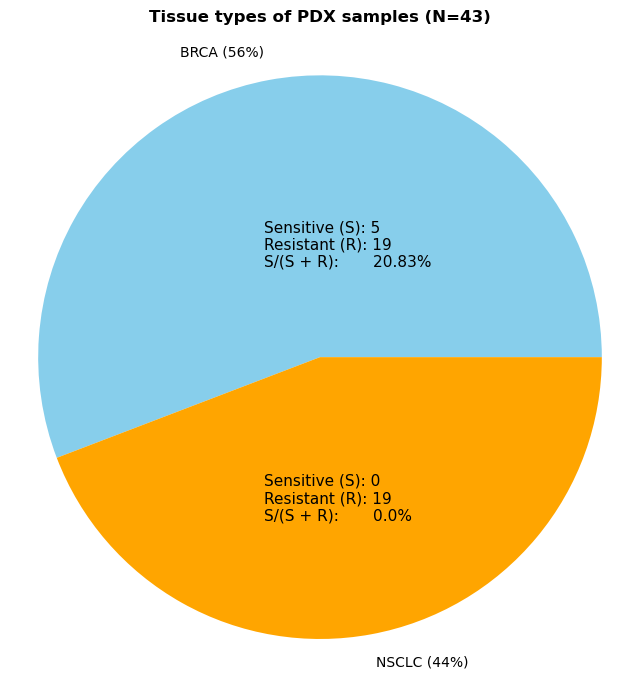

In [51]:
# plot tissue types of PDX samples 

labels = list(dat_pdx["Tumor Type"].value_counts().index)
sizes = list(dat_pdx["Tumor Type"].value_counts().astype(int))
total = sum(sizes)
labels_with_percentages = [f'{label} ({size/total*100:.0f}%)' for label, size in zip(labels, sizes)]

plt.figure(figsize=(8, 8))
plt.pie(sizes, labels=labels_with_percentages, startangle=0, colors=['skyblue','orange'])
plt.title(f'Tissue types of PDX samples (N={total})', fontweight = "bold", pad = 20)
plt.axis('equal')  

plt.text(-0.2, 0.4, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.text(-0.2, -0.5, 
         f'Sensitive (S): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)} \nResistant (R): {dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(0, 0)} \nS/(S + R):       {round(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts().get(1,0)/(sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "NSCLC","response"].value_counts())) * 100, 2)}%', 
         fontsize=11, 
         color='black',
         va='center')

plt.savefig(save_figures_to + 'Tissue types of PDX samples (Paclitaxel).png', format='png', bbox_inches='tight')

plt.show()

In [52]:
# filter BRCA cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "BRCA")
pdx_brca_samples = dat_pdx.loc[filter,].index
pdx_brca_samples

Index(['X-1008', 'X-1298', 'X-1371', 'X-1383', 'X-1407', 'X-1468', 'X-1600',
       'X-1916', 'X-1921', 'X-2195', 'X-2344', 'X-2487', 'X-2524', 'X-2780',
       'X-3298', 'X-3450', 'X-3873', 'X-4347', 'X-4567', 'X-4824', 'X-4949',
       'X-5502', 'X-5975', 'X-6047'],
      dtype='object')

In [53]:
# filter responses of BRCA cohort samples (Paclitaxel)

Ytspaclitaxel_brca = PDXRpaclitaxel.loc[pdx_brca_samples,"response"].values
Ytspaclitaxel_brca

array([1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 1, 0, 0, 0,
       1, 0])

In [54]:
# count of sensitive and resistance BRCA samples (Paclitaxel)

PDXRpaclitaxel.loc[pdx_brca_samples,"response"].value_counts()

response
0    19
1     5
Name: count, dtype: int64

In [55]:
# filter NSCLC cohort samples (Paclitaxel)

filter = (dat_pdx["Tumor Type"] == "NSCLC")
pdx_nsclc_samples = dat_pdx.loc[filter,].index
pdx_nsclc_samples

Index(['X-1156', 'X-1172', 'X-1323', 'X-1442', 'X-1499', 'X-1586', 'X-1787',
       'X-1823', 'X-1834', 'X-1835', 'X-1934', 'X-1980', 'X-1993', 'X-2017',
       'X-2042', 'X-2082', 'X-3237', 'X-3843', 'X-4819'],
      dtype='object')

In [56]:
# filter responses of NSCLC cohort samples (Paclitaxel)

Ytspaclitaxel_nsclc = PDXRpaclitaxel.loc[pdx_nsclc_samples,"response"].values
Ytspaclitaxel_nsclc

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0])

In [57]:
# define maximum iteration

max_iter = 50

In [58]:
# assign number of neurons and dropout rates found for layers from the saved models

hdm1 = 128
hdm2 = 16
hdm3 = 256
rate1 = 0.7
rate2 = 0.3
rate3 = 0.6
rate4 = 0.6

In [59]:
# load pre-trained models and make predictions

scalerGDSC = sk.StandardScaler()
scalerGDSC.fit(GDSCEv2.values)
X_trainE = scalerGDSC.transform(GDSCEv2.values)
X_testEpaclitaxel = scalerGDSC.transform(PDXEpaclitaxel.values) 
X_testEpaclitaxel_brca = scalerGDSC.transform(PDXEpaclitaxel.loc[pdx_brca_samples,].values) 

X_trainM = np.nan_to_num(GDSCMv2.values)
X_testMpaclitaxel = np.nan_to_num(PDXMpaclitaxel.values.astype(np.float32))
X_testMpaclitaxel_brca = np.nan_to_num(PDXMpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))

X_trainC = np.nan_to_num(GDSCCv2.values)
X_testCpaclitaxel = np.nan_to_num(PDXCpaclitaxel.values.astype(np.float32))
X_testCpaclitaxel_brca = np.nan_to_num(PDXCpaclitaxel.loc[pdx_brca_samples,].values.astype(np.float32))

TX_testEpaclitaxel = torch.FloatTensor(X_testEpaclitaxel)
TX_testEpaclitaxel_brca = torch.FloatTensor(X_testEpaclitaxel_brca)

TX_testMpaclitaxel = torch.FloatTensor(X_testMpaclitaxel.astype(np.float32))
TX_testMpaclitaxel_brca = torch.FloatTensor(X_testMpaclitaxel_brca.astype(np.float32))
TX_testCpaclitaxel = torch.FloatTensor(X_testCpaclitaxel.astype(np.float32))
TX_testCpaclitaxel_brca = torch.FloatTensor(X_testCpaclitaxel_brca.astype(np.float32))

ty_testEpaclitaxel = torch.FloatTensor(Ytspaclitaxel.astype(int))
ty_testEpaclitaxel_brca = torch.FloatTensor(Ytspaclitaxel_brca.astype(int))

n_sampE, IE_dim = X_trainE.shape
n_sampM, IM_dim = X_trainM.shape
n_sampC, IC_dim = X_trainC.shape

h_dim1 = hdm1
h_dim2 = hdm2
h_dim3 = hdm3        
Z_in = h_dim1 + h_dim2 + h_dim3

class AEE(nn.Module):
    def __init__(self):
        super(AEE, self).__init__()
        self.EnE = torch.nn.Sequential(
            nn.Linear(IE_dim, h_dim1),
            nn.BatchNorm1d(h_dim1),
            nn.ReLU(),
            nn.Dropout(rate1))
    def forward(self, x):
        output = self.EnE(x)
        return output  


class AEM(nn.Module):
    def __init__(self):
        super(AEM, self).__init__()
        self.EnM = torch.nn.Sequential(
            nn.Linear(IM_dim, h_dim2),
            nn.BatchNorm1d(h_dim2),
            nn.ReLU(),
            nn.Dropout(rate2))
    def forward(self, x):
        output = self.EnM(x)
        return output       

class AEC(nn.Module):
    def __init__(self):
        super(AEC, self).__init__()
        self.EnC = torch.nn.Sequential(
            nn.Linear(IC_dim, h_dim3),
            nn.BatchNorm1d(h_dim3),
            nn.ReLU(),
            nn.Dropout(rate3))
    def forward(self, x):
        output = self.EnC(x)
        return output 
        
class Classifier(nn.Module):
    def __init__(self):
        super(Classifier, self).__init__()
        self.FC = torch.nn.Sequential(
            nn.Linear(Z_in, 1),
            nn.Dropout(rate4),
            nn.Sigmoid())
    def forward(self, x):
        return self.FC(x)

torch.cuda.manual_seed_all(42)

AutoencoderE = torch.load(models_dir + "Exprs_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA.pt")
AutoencoderM = torch.load(models_dir + "Mut_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA.pt")
AutoencoderC = torch.load(models_dir + "CNA_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA.pt")

Clas = torch.load(models_dir + "Class_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA.pt")

AutoencoderE.eval()
AutoencoderM.eval()
AutoencoderC.eval()
Clas.eval()

ZEX = AutoencoderE(torch.FloatTensor(X_trainE))
ZMX = AutoencoderM(torch.FloatTensor(X_trainM))
ZCX = AutoencoderC(torch.FloatTensor(X_trainC))
ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
ZTX = F.normalize(ZTX, p=2, dim=0)
PredX = Clas(ZTX)
AUCT = roc_auc_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUC (PDX_CYTOi): {round(AUCT,2)}")
AUCTaucpr = average_precision_score(Y, PredX.detach().numpy())
#print(f"GDSC - Training AUCPR (PDX_CYTOi): {round(AUCTaucpr,2)}\n")

ZETpaclitaxel = AutoencoderE(TX_testEpaclitaxel)
ZMTpaclitaxel = AutoencoderM(TX_testMpaclitaxel)
ZCTpaclitaxel = AutoencoderC(TX_testCpaclitaxel)
ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZMTpaclitaxel, ZCTpaclitaxel), 1)
ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
PredTpaclitaxel = Clas(ZTTpaclitaxel)
AUCTpaclitaxel = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
AUCTpaclitaxel_aucpr = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
#print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}\n")

ZETpaclitaxel_brca = AutoencoderE(TX_testEpaclitaxel_brca)
ZMTpaclitaxel_brca = AutoencoderM(TX_testMpaclitaxel_brca)
ZCTpaclitaxel_brca = AutoencoderC(TX_testCpaclitaxel_brca)
ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZMTpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
PredTpaclitaxel_brca = Clas(ZTTpaclitaxel_brca)
AUCTpaclitaxel_brca = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
AUCTpaclitaxel_brca_aucpr = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
#print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}\n")

AUCT_finetuned = dict()
AUCTaucpr_finetuned = dict()
AUCTpaclitaxel_finetuned = dict()
AUCTpaclitaxel_brca_finetuned = dict()
AUCTpaclitaxel_aucpr_finetuned = dict()
AUCTpaclitaxel_brca_aucpr_finetuned = dict()
for iter in range(max_iter):
   iter += 1  

   AutoencoderE_finetuned = torch.load(models_dir + f"Finetuned_Models/Exprs_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderM_finetuned = torch.load(models_dir + f"Finetuned_Models/Mut_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   AutoencoderC_finetuned = torch.load(models_dir + f"Finetuned_Models/CNA_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   Clas_finetuned = torch.load(models_dir + f"Finetuned_Models/Class_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{iter}.pt")
   
   AutoencoderE_finetuned.eval()
   AutoencoderM_finetuned.eval()
   AutoencoderC_finetuned.eval()
   Clas_finetuned.eval()
      
   ZEX = AutoencoderE_finetuned(torch.FloatTensor(X_trainE))
   ZMX = AutoencoderM_finetuned(torch.FloatTensor(X_trainM))
   ZCX = AutoencoderC_finetuned(torch.FloatTensor(X_trainC))
   ZTX = torch.cat((ZEX, ZMX, ZCX), 1)
   ZTX = F.normalize(ZTX, p=2, dim=0)
   PredX = Clas_finetuned(ZTX)
   AUCT_finetuned[iter] = roc_auc_score(Y, PredX.detach().numpy())
   AUCTaucpr_finetuned[iter] = average_precision_score(Y, PredX.detach().numpy())
   
   ZETpaclitaxel = AutoencoderE_finetuned(TX_testEpaclitaxel)
   ZMTpaclitaxel = AutoencoderM_finetuned(TX_testMpaclitaxel)
   ZCTpaclitaxel = AutoencoderC_finetuned(TX_testCpaclitaxel)
   ZTTpaclitaxel = torch.cat((ZETpaclitaxel, ZMTpaclitaxel, ZCTpaclitaxel), 1)
   ZTTpaclitaxel = F.normalize(ZTTpaclitaxel, p=2, dim=0)
   PredTpaclitaxel = Clas_finetuned(ZTTpaclitaxel)
   AUCTpaclitaxel_finetuned[iter] = roc_auc_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())
   AUCTpaclitaxel_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel.astype(int), PredTpaclitaxel.detach().numpy())

   ZETpaclitaxel_brca = AutoencoderE_finetuned(TX_testEpaclitaxel_brca)
   ZMTpaclitaxel_brca = AutoencoderM_finetuned(TX_testMpaclitaxel_brca)
   ZCTpaclitaxel_brca = AutoencoderC_finetuned(TX_testCpaclitaxel_brca)
   ZTTpaclitaxel_brca = torch.cat((ZETpaclitaxel_brca, ZMTpaclitaxel_brca, ZCTpaclitaxel_brca), 1)
   ZTTpaclitaxel_brca = F.normalize(ZTTpaclitaxel_brca, p=2, dim=0)
   PredTpaclitaxel_brca = Clas_finetuned(ZTTpaclitaxel_brca)
   AUCTpaclitaxel_brca_finetuned[iter] = roc_auc_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())
   AUCTpaclitaxel_brca_aucpr_finetuned[iter] = average_precision_score(Ytspaclitaxel_brca.astype(int), PredTpaclitaxel_brca.detach().numpy())

max_key = max(AUCTpaclitaxel_aucpr_finetuned, key=AUCTpaclitaxel_aucpr_finetuned.get)
max_key_brca = max(AUCTpaclitaxel_brca_aucpr_finetuned, key=AUCTpaclitaxel_brca_aucpr_finetuned.get)

print(f"GDSC - Training AUC (CYTOi): {round(AUCT,2)}")
print(f"GDSC - Training AUCPR (CYTOi): {round(AUCTaucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}")
print(f"PDX - Test AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca,2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA): {round(AUCTpaclitaxel_brca_aucpr,2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key],2)}")
print(f"PDX - Test AUC (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_finetuned[max_key],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, Finetuned): {round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)}\n")

print(f"GDSC - Training AUC (CYTOi, Finetuned): {round(AUCT_finetuned[max_key_brca],2)}")
print(f"GDSC - Training AUCPR (CYTOi, Finetuned): {round(AUCTaucpr_finetuned[max_key_brca],2)}")
print(f"PDX - Test AUC (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)}")
print(f"PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): {round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)}\n\n")

print("Models for maximum finetuning (Paclitaxel)")
print(f"Exprs_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key}.pt")


print("\nModels for maximum finetuning (Paclitaxel, BRCA)")
print(f"Exprs_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"Mut_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"CNA_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")
print(f"Class_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_{max_key_brca}.pt")

GDSC - Training AUC (CYTOi): 0.7
GDSC - Training AUCPR (CYTOi): 0.23
PDX - Test AUC (Paclitaxel): 0.89
PDX - Test AUCPR (Paclitaxel): 0.42
PDX - Test AUC (Paclitaxel, BRCA): 0.89
PDX - Test AUCPR (Paclitaxel, BRCA): 0.69

GDSC - Training AUC (CYTOi, Finetuned): 0.71
GDSC - Training AUCPR (CYTOi, Finetuned): 0.23
PDX - Test AUC (Paclitaxel, Finetuned): 0.87
PDX - Test AUCPR (Paclitaxel, Finetuned): 0.42

GDSC - Training AUC (CYTOi, Finetuned): 0.71
GDSC - Training AUCPR (CYTOi, Finetuned): 0.23
PDX - Test AUC (Paclitaxel, BRCA, Finetuned): 0.88
PDX - Test AUCPR (Paclitaxel, BRCA, Finetuned): 0.72


Models for maximum finetuning (Paclitaxel)
Exprs_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_39.pt
Mut_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_39.pt
CNA_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_39.pt
Class_Paclitaxel_GDSC_PDX_CYTOi_Expression_Mutation_CNA_Finetuned_39.pt

Models for maximum finetuning (Paclitaxel, BRCA)
Exprs_Paclitaxel_G

In [60]:
# show expression layer parameters

AutoencoderE

AEE(
  (EnE): Sequential(
    (0): Linear(in_features=708, out_features=128, bias=True)
    (1): BatchNorm1d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.7, inplace=False)
  )
)

In [61]:
# show mutation layer parameters

AutoencoderM

AEM(
  (EnM): Sequential(
    (0): Linear(in_features=708, out_features=16, bias=True)
    (1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.3, inplace=False)
  )
)

In [62]:
# show CNA layer parameters

AutoencoderC

AEC(
  (EnC): Sequential(
    (0): Linear(in_features=708, out_features=256, bias=True)
    (1): BatchNorm1d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): Dropout(p=0.6, inplace=False)
  )
)

In [63]:
# show classification layer parameters

Clas

Classifier(
  (FC): Sequential(
    (0): Linear(in_features=400, out_features=1, bias=True)
    (1): Dropout(p=0.6, inplace=False)
    (2): Sigmoid()
  )
)

In [64]:
# create a dataframe with the prediction results 

emc = {"Data": ["Expr + Mut + CNA", "Expr + Mut + CNA (Fine-tuned)"],
       "AUC (GDSC)": [round(AUCT, 2), round(AUCT_finetuned[max_key], 2)],
       "AUCPR (GDSC)": [round(AUCTaucpr,2), round(AUCTaucpr_finetuned[max_key],2)],
       "AUC (PDX)": [round(AUCTpaclitaxel,2), round(AUCTpaclitaxel_finetuned[max_key],2)],
       "AUCPR (PDX)":  [round(AUCTpaclitaxel_aucpr,2), round(AUCTpaclitaxel_aucpr_finetuned[max_key],2)],
       "AUC (PDX-BRCA)":  [round(AUCTpaclitaxel_brca,2), round(AUCTpaclitaxel_brca_finetuned[max_key_brca],2)],
       "AUCPR (PDX-BRCA)": [round(AUCTpaclitaxel_brca_aucpr,2), round(AUCTpaclitaxel_brca_aucpr_finetuned[max_key_brca],2)],
       "Sample Size (GDSC)": [GDSCEv2.shape[0], GDSCEv2.shape[0]],
       "Feature Size (GDSC)": [GDSCEv2.shape[1], GDSCEv2.shape[1]] 
}
emc_dataframe = pd.DataFrame.from_dict(emc, orient='index').transpose()  
emc_dataframe.to_csv(save_results_to + "GDSC_PDX_Expression_Mutation_CNA_CYTOi_Paclitaxel.tsv",
                    sep = "\t",
                    index = False)

emc_dataframe.rename(columns = {
    "AUC (GDSC)": "AUC (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUCPR (GDSC)": "AUCPR (GDSC, N=" + str(GDSCEv2.shape[0]) + ")",
    "AUC (PDX)": "AUC (PDX, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUCPR (PDX)": "AUCPR (PDX, N=" + str(len(Ytspaclitaxel)) + ")",
    "AUC (PDX-BRCA)": "AUC (PDX-BRCA, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int)))) + ")",
    "AUCPR (PDX-BRCA)": "AUCPR (PDX-BRCA, N=" + str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int)))) + ")",
    }, inplace = True
)

emc_dataframe

,Data,"AUC (GDSC, N=7561)","AUCPR (GDSC, N=7561)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)",Sample Size (GDSC),Feature Size (GDSC)
0,Expr + Mut + CNA,0.7,0.23,0.89,0.42,0.89,0.69,7561,708
1,Expr + Mut + CNA (Fine-tuned),0.71,0.23,0.87,0.42,0.88,0.72,7561,708


In [65]:
# merge all EM, EC, and EMC dataframes 

ec_dataframe = pd.read_csv(ec_dir + "GDSC_PDX_Expression_CNA_CYTOi_Paclitaxel.tsv",
                           sep = "\t")
ec_dataframe.columns = emc_dataframe.columns

em_dataframe = pd.read_csv(em_dir + "GDSC_PDX_Expression_Mutation_CYTOi_Paclitaxel.tsv",
                           sep = "\t")
em_dataframe.columns = emc_dataframe.columns

all_dataframe = pd.concat([emc_dataframe, ec_dataframe, em_dataframe], axis = 0)
all_dataframe.set_index("Data", inplace = True)

all_dataframe

,"AUC (GDSC, N=7561)","AUCPR (GDSC, N=7561)","AUC (PDX, N=43)","AUCPR (PDX, N=43)","AUC (PDX-BRCA, N=24)","AUCPR (PDX-BRCA, N=24)",Sample Size (GDSC),Feature Size (GDSC)
Data,,,,,,,,
Expr + Mut + CNA,0.7,0.23,0.89,0.42,0.89,0.69,7561,708
Expr + Mut + CNA (Fine-tuned),0.71,0.23,0.87,0.42,0.88,0.72,7561,708
Expr + CNA,0.65,0.2,0.62,0.18,0.66,0.34,7561,835
Expr + CNA (Fine-tuned),0.69,0.22,0.64,0.34,0.72,0.54,7561,835
Expr + Mut,0.74,0.27,0.53,0.14,0.57,0.26,7561,710
Expr + Mut (Fine-tuned),0.74,0.27,0.68,0.22,0.57,0.42,7561,710


In [66]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

auc_dataframe = all_dataframe[[f"AUC (GDSC, N={str(GDSCEv2.shape[0])})",
                               f"AUC (PDX, N={str(len(Ytspaclitaxel))})",
                               f"AUC (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})"]]


auc_dataframe.rename(
    columns = {
        f"AUC (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUC (PDX, N={str(len(Ytspaclitaxel))})": f"PDX (N={str(len(Ytspaclitaxel))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUC (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})": f"PDX-BRCA (N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
auc_dataframe

,"GDSC (N=7561, p=708\nS=866, R=6695, S/N=0.11)","PDX (N=43, p=708\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=708\nS=5, R=19, S/N=0.21)"
Data,,,
Expr + Mut + CNA,0.7,0.89,0.89
Expr + Mut + CNA (Fine-tuned),0.71,0.87,0.88
Expr + CNA,0.65,0.62,0.66
Expr + CNA (Fine-tuned),0.69,0.64,0.72
Expr + Mut,0.74,0.53,0.57
Expr + Mut (Fine-tuned),0.74,0.68,0.57


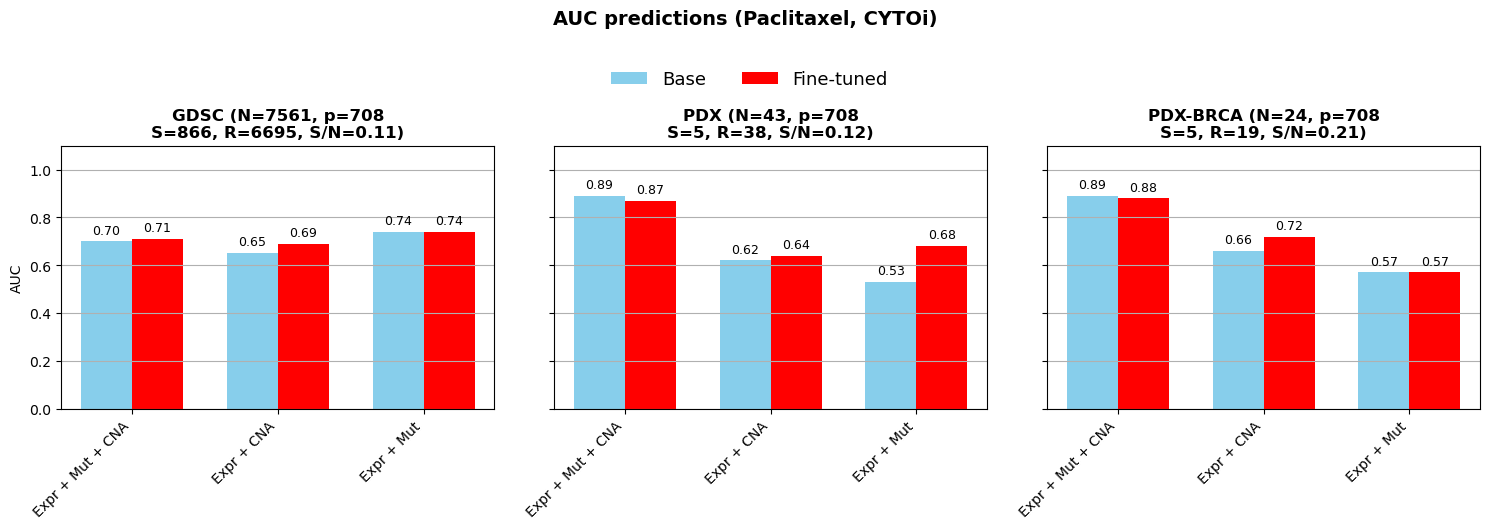

In [67]:
# plot AUC scores

df = auc_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUC')
fig.suptitle('AUC predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUC Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [68]:
# change column names including sample size, feature size, count of resistant and sensitive samples, and sensitivity ratio 

aucpr_dataframe = all_dataframe[[f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})",
                                 f"AUCPR (PDX, N={str(len(Ytspaclitaxel))})",
                                 f"AUCPR (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})"]]


aucpr_dataframe.rename(
    columns = {
        f"AUCPR (GDSC, N={str(GDSCEv2.shape[0])})": f"GDSC (N={str(GDSCEv2.shape[0])}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(GDSCR["response"].value_counts()[1]) + ", R=" + str(GDSCR["response"].value_counts()[0]) + ", S/N=" + str(round(GDSCR["response"].value_counts()[1]/sum(GDSCR["response"].value_counts()), 2)) + ")",
        f"AUCPR (PDX, N={str(len(Ytspaclitaxel))})": f"PDX (N={str(len(Ytspaclitaxel))}, p=" + str(GDSCEv2.shape[1]) + "\nS=" + str(PDXRpaclitaxel["response"].value_counts()[1]) + ", R=" + str(PDXRpaclitaxel["response"].value_counts()[0]) + ", S/N=" + str(round(PDXRpaclitaxel["response"].value_counts()[1]/sum(PDXRpaclitaxel["response"].value_counts()), 2)) + ")",        
        f"AUCPR (PDX-BRCA, N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))})": f"PDX-BRCA (N={str(sum(list(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts().astype(int))))}, p=" + str(PDXEpaclitaxel.shape[1]) + "\nS=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]) + ", R=" + str(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[0]) + ", S/N=" + str(round(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()[1]/sum(dat_pdx.loc[dat_pdx["Tumor Type"] == "BRCA","response"].value_counts()), 2)) + ")",        
    }, inplace = True
)
aucpr_dataframe

,"GDSC (N=7561, p=708\nS=866, R=6695, S/N=0.11)","PDX (N=43, p=708\nS=5, R=38, S/N=0.12)","PDX-BRCA (N=24, p=708\nS=5, R=19, S/N=0.21)"
Data,,,
Expr + Mut + CNA,0.23,0.42,0.69
Expr + Mut + CNA (Fine-tuned),0.23,0.42,0.72
Expr + CNA,0.2,0.18,0.34
Expr + CNA (Fine-tuned),0.22,0.34,0.54
Expr + Mut,0.27,0.14,0.26
Expr + Mut (Fine-tuned),0.27,0.22,0.42


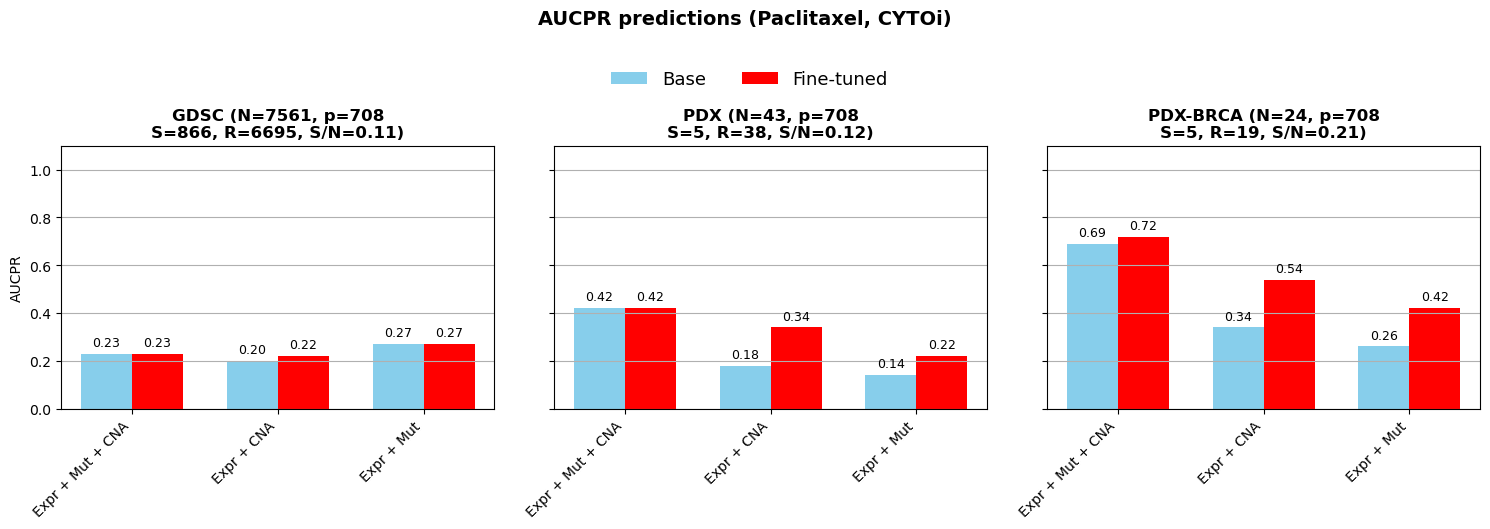

In [69]:
# plot AUCPR scores

df = aucpr_dataframe
index_labels = list(df.index)
group_count = df.shape[0] // 2 

fig, axes = plt.subplots(nrows=1, ncols=df.shape[1], figsize=(15, 5), sharey=True)

bar_width = 0.35
x = np.arange(group_count)  

# Generate grouped bar plots
for i, ax in enumerate(axes):
    col = df.columns[i]
    
    bars1 = df.iloc[::2, i]  
    bars2 = df.iloc[1::2, i]  

    rects1 = ax.bar(x - bar_width/2, bars1, width=bar_width, label='Base', color='skyblue')
    rects2 = ax.bar(x + bar_width/2, bars2, width=bar_width, label='Fine-tuned', color='red')

    ax.set_title(col, fontsize=12, fontweight="bold")
    ax.set_ylim(0, 1.1)
    ax.set_xticks(x)
    
    xtick_labels = df.index[::2]
    ax.set_xticklabels(xtick_labels, rotation=45, ha="right", fontsize=10)
    ax.grid(axis='y')

    for rect in rects1 + rects2:
        height = rect.get_height()
        ax.text(rect.get_x() + rect.get_width() / 2, height + 0.02, f'{height:.2f}', ha='center', va='bottom', fontsize=9)

axes[0].set_ylabel('AUCPR')
fig.suptitle('AUCPR predictions (Paclitaxel, CYTOi)', fontsize=14, fontweight="bold", y=1.05)

fig.legend(
    handles=[rects1, rects2],
    labels=["Base", "Fine-tuned"],
    loc='upper left',
    bbox_to_anchor=(0.4, 0.96),
    ncol=2,
    frameon=False,
    fontsize=13
)

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.savefig(save_figures_to + "AUCPR Plot (Paclitaxel, CYTOi).png", bbox_inches='tight', pad_inches=0.5)
plt.show()

In [70]:
# change directory

os.chdir(save_results_to)
print(os.getcwd())

/Volumes/Expansion/Thesis Work/Results/Transfer Learning/Drugs with same pathways/PDX_CYTOi/Expression_Mutation_CNA/Predictions


In [71]:
# save predictions

file = open('GDSC_PDX_DEGs - PDX_CYTOi_Paclitaxel Predictions (Expression, Mutation, and CNA).txt', 'w')
file.write(f"GDSC Training (EMC) AUC (PDX_CYTOi): {round(AUCT,2)}\n")
file.write(f"GDSC Training (EMC) AUCPR (PDX_CYTOi): {round(AUCTaucpr,2)}\n\n")

file.write(f"PDX Test (EMC) AUC (Paclitaxel): {round(AUCTpaclitaxel,2)}\n")
file.write(f"PDX Test (EMC) AUCPR (Paclitaxel): {round(AUCTpaclitaxel_aucpr,2)}\n\n")

file.close()